# De Rham Neural Networks

In this notebook, we develop a few examples of simple De Rham Neural Networks.

In [1]:
import numpy as np
import matplotlib as mpl
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

## Vector Fields

As a first example, we will consider vector fields over $\mathbb{R}^2$. $1$-forms, which are in bijection with and dual to vector fields, can be written in the form:
$\begin{equation} \omega = f_x(x,y) dx + f_y(x,y) dy \end{equation}$ where both $f_x$ and $f_y$ are functions from $\mathbb{R}^2$ to $\mathbb{R}$. By the identification
$ \begin{equation} \mathsf{Hom}(\mathbb{R}^2, \mathbb{R}) \oplus  \mathsf{Hom}(\mathbb{R}^2, \mathbb{R}) \cong \mathsf{Hom}(\mathbb{R}^2, \mathbb{R}^2)  \end{equation}$ we can represent a $1$-form as a single function from $\mathbb{R}^2 \to \mathbb{R}^2$. To learn such a function, we define a simple MLP below which goes from $\mathbb{R}^2 \to \mathbb{R}^2$.

In [2]:
import torch
import torch.nn as nn
 
c = 6 # number of features/columns in cochain data matrix

vf = nn.Sequential(
    nn.Linear(2, 2*c)
)

To drive home the fact that the above MLP actually defines a vector field, we can plot it. The 'tangent vector' at each point $(x,y) \in \mathbb{R}^2$ is the vector given by
$\begin{equation}  (f_x(x,y),f_y(x,y)) \end{equation}$ which corresponds to the MLP above via
$\begin{equation} f_x(x,y) = \pi_x \circ \text{vf.forward}(x,y) \end{equation}$ and $\begin{equation} f_y(x,y) = \pi_y \circ \text{vf.forward}(x,y). \end{equation}$

/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_861/2424882568.py:29: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 3, i+1)


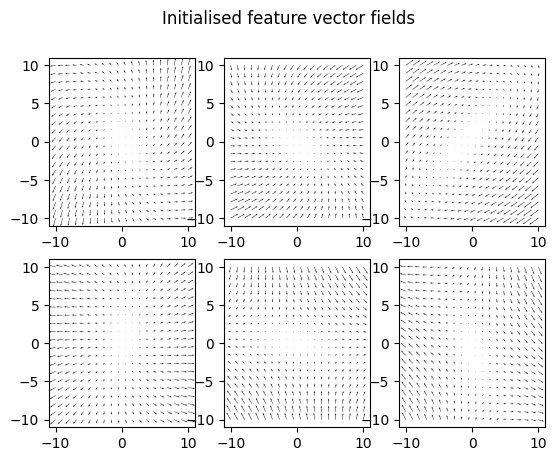

In [3]:
## plot a vector field given a function f: R^2 -> R^2
def plot_component_vf(f, ax, comp = 0, x_range=5, y_range=5):

    x = np.linspace(-x_range,x_range,20)
    y = np.linspace(-y_range,y_range,20)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((20,20))
    V = np.zeros((20,20))
    for i in range(20):
        for j in range(20):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor(inp).float()

            tv = f.forward(inp).reshape(2,c)

            U[i,j] = tv[:,comp][0]
            V[i,j] = tv[:,comp][1]
    ax.quiver(X,Y,U,V)

fig, ax = plt.subplots()

# make a figure with 6 subplots arranged in 2 rows and 3 columns
for i in range(c):
    ax = plt.subplot(2, 3, i+1)
    plot_component_vf(vf, ax, comp = i, x_range=10, y_range=10)


# add a title to the figure
fig.suptitle('Initialised feature vector fields')


plt.show()


## Integration Paths Agains Vector Fields


In [7]:
# a function for turning a path into a chain
def path_to_chain(p):
    """  
    A function for turning a path into a chain

    Parameters
    ----------
    p : numpy array
        A path in R^n, represented as a numpy array of shape (p,n), where p is the number of points in the path

    Returns
    -------
    chain : numpy array
        A chain in R^n, represented as a numpy array of shape (p-1,2,n), where p is the number of points in the path.
        The middle index corresponds to start and endpoints of the edges in the chain.
    """

    r = len(p) - 1

    n = p[0].shape[0]
    
    
    chain = torch.zeros((r,2,n))

    chain[:,1,:] = torch.tensor(p[1:,:])
    chain[:,0,:] = torch.tensor(p[0:-1,:])

    return chain

    
# a function for turning a chain into a discretized chain
def discretize_chain(chain,d):
    """ 
    A function for turning a chain into a discretized chain

    Parameters
    ----------
    chain : numpy array
        A chain in R^n, represented as a numpy array of shape (p-1,2,n), where p is the number of points in the path.

    d : int
        The number of points in the discretized chain

    Returns
    -------
    d_chain : numpy array
        A discretized chain in R^n, represented as a numpy array of shape (p-1,d,n), where p is the number of points in the path.

    """

    r = chain.shape[0]

    n = chain.shape[2]

    d_chain = torch.zeros((r,d,n))

    t = np.linspace(0,1,d)

    for i in range(d):

        d_chain[:,i,:] = (1-t[i]) * chain[:,0,:] + t[i] * chain[:,1,:] 

    return d_chain



In [10]:
# a function for turning a chain into a cochain data matrix
def gen_CDM2(vf,chain, d = 5):
    """
    A function for generating a cochain data matrix from a chain and a vector field

    Parameters
    ----------
    vf : a Pytorch Sequential object
        The vector field to be applied to the chain
    
    \chain : a torch tensor of shape (r,2,n)
        The chain to be turned into a cochain data matrix

    d : int
        The number of discrete steps in the discretization of the chain
    
    Returns
    -------
    out : a torch tensor of shape (r,c)
        The cochain data matrix
    """

    
    # discretize the chain
    chain = discretize_chain(chain, d)

    # number of simplicies
    r = chain.shape[0]

    # number of discrete steps
    d = chain.shape[1]

    # dimension of ambient space
    n = chain.shape[2]

    # number of feature-cochains in the cochain data matrix
    c = int(vf[-1].out_features / n)

    # apply the vector field to the discretized chain
    out = vf(chain).reshape((r,d,n,c))

    # calculate the simplex gradients
    simplex_grad = chain[:,1,:] - chain[:,0,:]

    # swap dimensions n and c in out
    out = out.permute(0,1,3,2)

    # calculate the inner product of the vector field and the simplex gradients at each discrete step on each simplex
    inner_prod = torch.matmul(out,simplex_grad.T/(d-1))

    # take diagonal of out3 along axis 0 and 3 (this corresponds to correcting the broadcasted multplication effect)
    inner_prod = torch.diagonal(inner_prod, dim1 = 0, dim2 = 3)

    # permute dimensions 0 and 2 of out4
    inner_prod = inner_prod.permute(2,0,1)

    # apply the trapzoidal rule to the inner product
    cdm = (inner_prod[:,1:,:] + inner_prod[:,0:-1,:])/2
    cdm = cdm.sum(axis = 1)

    return cdm

### Synthetic Dataset of paths

In [12]:
## plot a set of points and connect consecutive points with lines
def plot_points(points, ax, color = 'black', alpha = 1, linewidth = 1):

    n = points.shape[0]

    for i in range(n-1):
        ax.plot(points[i:i+2,0],points[i:i+2,1], color = color, alpha = alpha, linewidth = linewidth)

    return ax


In [13]:
def generate_diagonal_paths(num_paths=100,eps = 0.02, num_pts = 50):
    
    Paths = []
    for i in range(num_paths): 
        x = np.sort(np.random.uniform(low=-1, high=1, size=num_pts))
        noise_x= np.random.uniform(low= -eps, high = eps,  size = num_pts)
        noise_y= np.random.uniform(low= -eps, high = eps,  size = num_pts)

        x_trans = np.random.randint(-2,2)
        y_trans = np.random.randint(-2,2)

        r = np.random.uniform(0.2, 2.5)

        x_values = list(r*x+noise_x+x_trans)
        y_values = list(r*np.sin(x+noise_y)+ y_trans)

        path = np.stack((x_values,y_values))
    
        Paths.append(path.T)
        
    return Paths


def generate_antidiagonal_paths(num_paths=100,eps = 0.01, num_pts = 50):
    
    Paths = []
    for i in range(num_paths): 
        x = np.sort(np.random.uniform(low=-1, high=1, size=num_pts))

        noise_x= np.random.uniform(low= -eps, high = eps,  size = num_pts)
        noise_y= np.random.uniform(low= -eps, high = eps,  size = num_pts)

        x_trans = np.random.randint(-2,2)
        y_trans = np.random.randint(-2,2)

        r = np.random.uniform(0.2, 2.5)

        x_values = list(r*x+noise_x + x_trans)
        y_values = list(-r*np.sin(x+noise_y)+y_trans)
        path = np.stack((x_values,y_values))
    
        Paths.append(path.T)
        
    return Paths
        



def generate_circular_paths(num_paths=100,eps = 0.02, num_pts = 50):
    
    Paths = []
    for i in range(num_paths): 
        endpoint = np.random.randint(0,num_pts)

        k = np.random.randint(1,4)
        phase = np.random.uniform(0,2*np.pi)
        
        sample_angles = list(np.sort(np.random.uniform(0,2*np.pi/k, num_pts)+phase))

        #angles= sample_angles[endpoint:]+ sample_angles[:endpoint]
        angles = np.array(sample_angles)
        
        noise_x= np.random.uniform(low= -eps, high = eps,  size = num_pts)
        noise_y= np.random.uniform(low= -eps, high = eps,  size = num_pts)

        x_trans = np.random.randint(-5,5)
        y_trans = np.random.randint(-5,5)

        r = np.random.uniform(0.2, 2.5)

        x_values = r*np.cos(angles)+noise_x
        y_values = r*np.sin(angles)+noise_y

        path = np.stack((x_values,y_values))
    
        Paths.append(path.T)

    return Paths

In [14]:
# generate data
noise = 0.05
pts = 30

p0 = generate_diagonal_paths(num_paths=100,eps = noise, num_pts = 50)
p1 = generate_antidiagonal_paths(num_paths=100,eps = noise, num_pts = 50)
p2 = generate_circular_paths(num_paths=100,eps = noise, num_pts = 50)

# join together p0, p1, p2
paths = p0+p1+p2

In [15]:
# generate labels
labels = np.concatenate((np.zeros(100),np.ones(100),2*np.ones(100)))

# perform a one hot encoding of the labels and transform to torch
labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64))

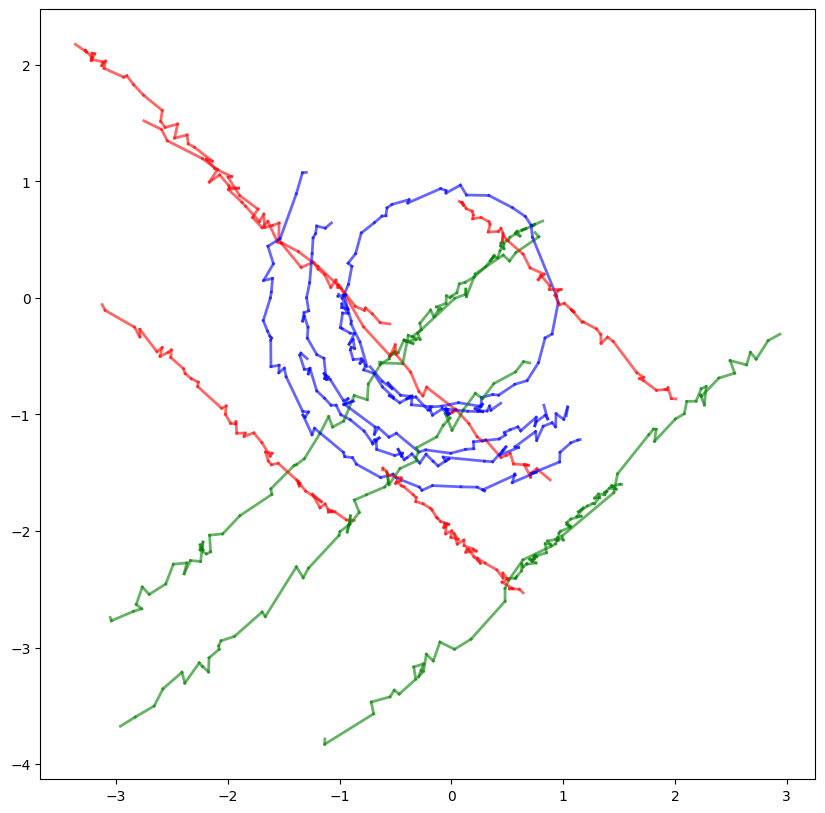

In [16]:
fig, ax = plt.subplots(1,1,figsize = (10,10))

for i in range(5):


    plot_points(paths[0+i], ax, color = 'green', alpha = 0.6, linewidth = 2)

    plot_points(paths[100+i], ax, color = 'red', alpha = 0.6, linewidth = 2)

    plot_points(paths[200+i], ax, color = 'blue', alpha = 0.6, linewidth = 2)

plt.show()

In [17]:
# a function for calculating the length of a path
def path_length(path):
    """
    Calculates the length of a path
    """
    length = 0
    for i in range(len(path)-1):
        length += np.linalg.norm(path[i+1]-path[i])
    return length

### Running the model

First up, we initialise the vector field as a simple MLP with ReLU activations.

In [20]:
c = 3 # number of features/columns in cochain data matrix

vf = nn.Sequential(
    nn.Linear(2, 50),
    nn.ReLU(),
    nn.Linear(50, 30),
    nn.ReLU(),
    nn.Linear(30, 2*c)
)

We can plot the corresponding vector fields below. Note that these are a result of the standard random weight initialisations. 

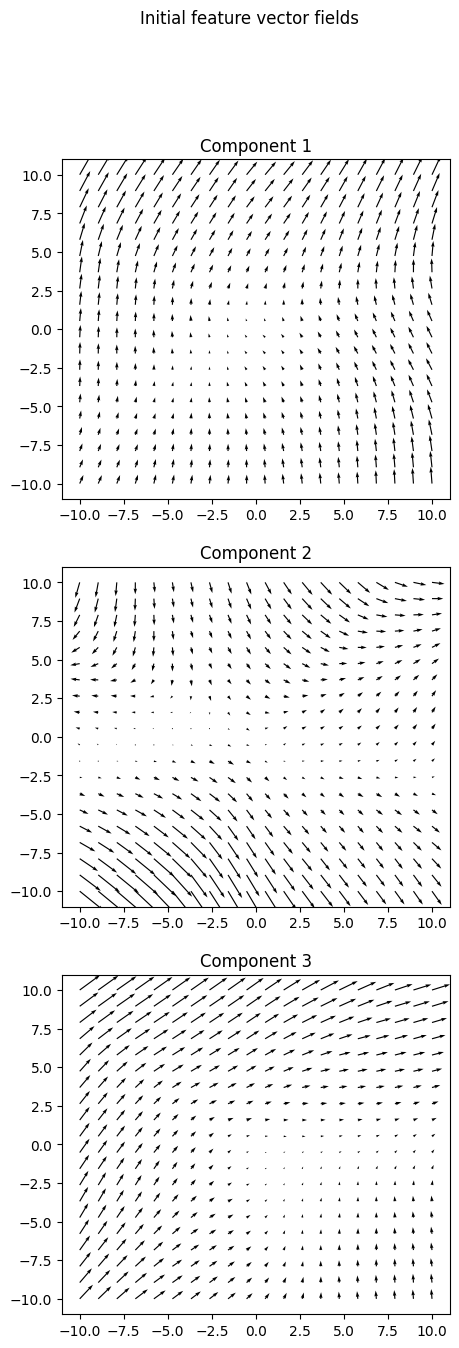

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(5, 15))

for i in range(3):
    ax = axs[i]
    plot_component_vf(vf, ax, comp = i, x_range=10, y_range=10)
    ax.set_title('Component {}'.format(i+1))

# add a title to the figure
fig.suptitle('Initial feature vector fields')

plt.show()

By looking at the summed rows of the corresponding cochain data matrix, we get a mapping from each path to R^3, where 3 is the number of feature vector fields and the coordinates corespond to integration along each vector field. As we can see, the initialised vector fields do not generate representations that separate the paths into the three classes.

/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_2720/334403156.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(torch.nn.functional.softmax(X))


Accuracy: 0.23666666666666666


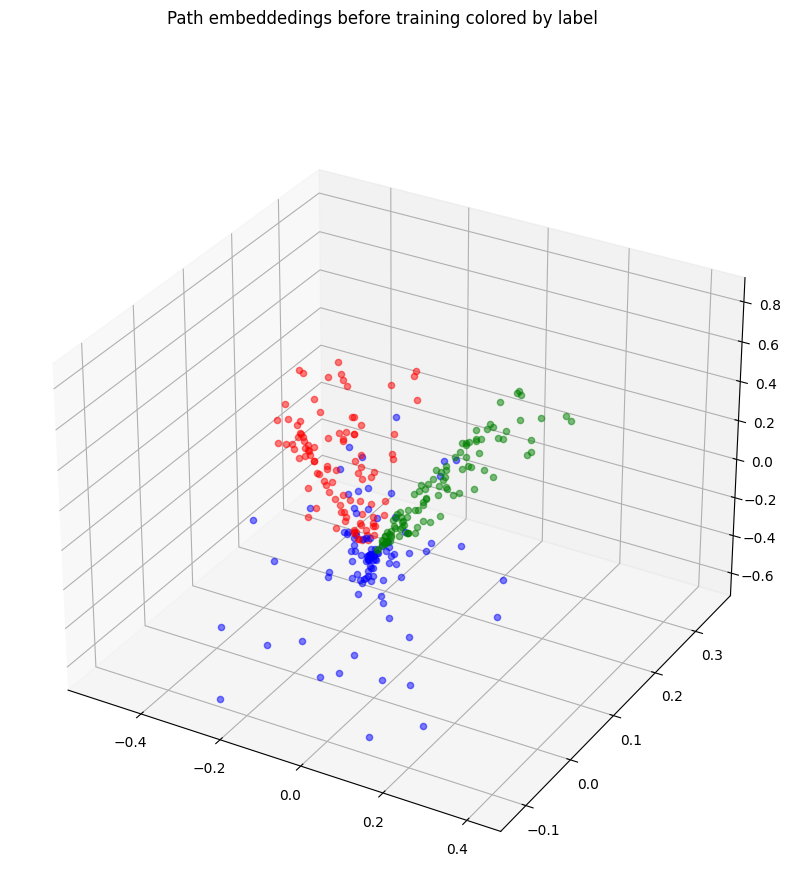

In [22]:
# make a 3d scatter plot of vf evaluated on the set of paths, colored by labels
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

correct = 0

for i in range(len(paths)):
        
        p = paths[i]
        l = labels[i]

        p = path_to_chain(p)
        
        X = gen_CDM2(vf, p, d = 5)
        
        X = torch.sum(X, dim = 0)

        lb = torch.argmax(l)

        pred = torch.argmax(torch.nn.functional.softmax(X))

        if pred == lb:
            correct +=1
        
        
        if lb == 0:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'green', alpha = 0.5)
        elif lb == 1:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'red', alpha = 0.5)
        elif lb == 2:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'blue', alpha = 0.5)


print('Accuracy: {}'.format(correct/len(paths)))


# add a title to the figure
fig.suptitle('Path embeddedings before training colored by label')

plt.show()

### Training and Gradient Descent

Now we begin the training phase. We use stand SGD with a learning rate of 0.01 and a momentum of 0.9. We train for 50 epoches and employ a Cross-Entropy loss.

In [24]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(vf.parameters(), lr=1e-2)

criterion = nn.CrossEntropyLoss()


/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_2720/263785379.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sm = torch.nn.functional.softmax(X)


Epoch =  0 Loss =  tensor(1.0368)
Epoch =  1 Loss =  tensor(0.8845)
Epoch =  2 Loss =  tensor(0.8014)
Epoch =  3 Loss =  tensor(0.7621)
Epoch =  4 Loss =  tensor(0.7406)
Epoch =  5 Loss =  tensor(0.7271)
Epoch =  6 Loss =  tensor(0.7173)
Epoch =  7 Loss =  tensor(0.7096)
Epoch =  8 Loss =  tensor(0.7030)
Epoch =  9 Loss =  tensor(0.6971)
Epoch =  10 Loss =  tensor(0.6912)
Epoch =  11 Loss =  tensor(0.6856)
Epoch =  12 Loss =  tensor(0.6807)
Epoch =  13 Loss =  tensor(0.6763)
Epoch =  14 Loss =  tensor(0.6725)
Epoch =  15 Loss =  tensor(0.6690)
Epoch =  16 Loss =  tensor(0.6657)
Epoch =  17 Loss =  tensor(0.6624)
Epoch =  18 Loss =  tensor(0.6587)
Epoch =  19 Loss =  tensor(0.6542)
Epoch =  20 Loss =  tensor(0.6501)
Epoch =  21 Loss =  tensor(0.6462)
Epoch =  22 Loss =  tensor(0.6420)
Epoch =  23 Loss =  tensor(0.6368)
Epoch =  24 Loss =  tensor(0.6342)
Epoch =  25 Loss =  tensor(0.6302)
Epoch =  26 Loss =  tensor(0.6276)
Epoch =  27 Loss =  tensor(0.6244)
Epoch =  28 Loss =  tensor(0.6

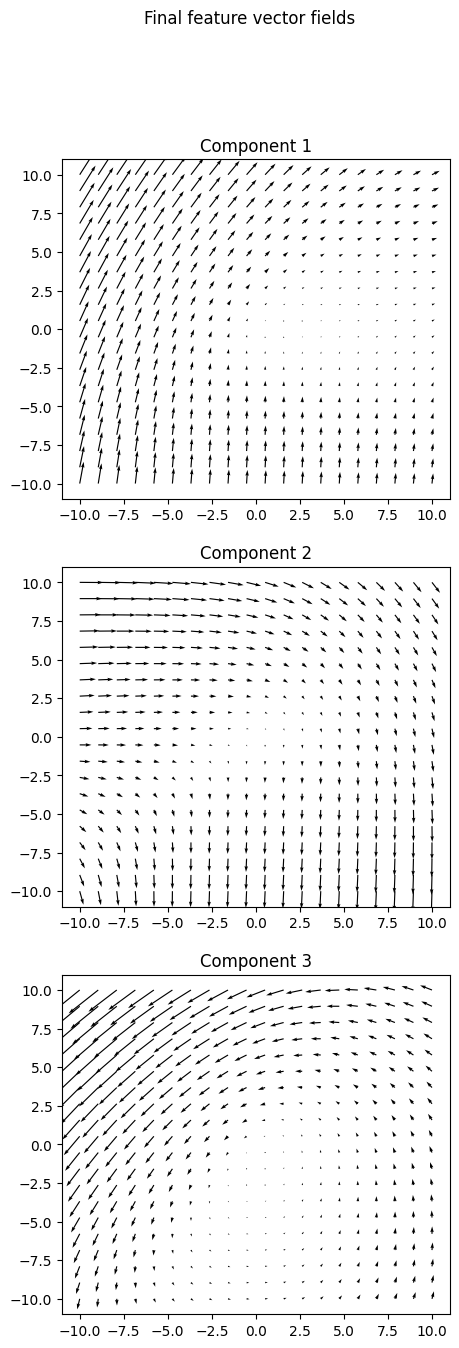

In [25]:
epochs = 50

batch_size = 300

losses = torch.zeros((batch_size,epochs))

for j in range(epochs):

    # make a random choice of size batch_size
    idx = np.random.choice(len(paths), size=batch_size, replace=False)

    batch_paths = [paths[i] for i in idx]
    batch_labels = labels[idx]

        
    for i in range(batch_size):

        p = batch_paths[i]
        l = batch_labels[i]

        p = path_to_chain(p)
        
        X = gen_CDM2(vf, p, d = 5)
        X = torch.sum(X, dim = 0)

        sm = torch.nn.functional.softmax(X)


        loss = criterion(sm,l.float())

        losses[i,j] = loss.detach()

        
        loss.backward()

        # for some reason it works better doing the backprop/gradient step after each path

        optimizer.step()

        optimizer.zero_grad()

    # clear print statement from previous iteration
    # clear_output(wait=True)
    
    print("Epoch = ", j, "Loss = ", torch.sum(losses[:,j])/batch_size)


fig, axs = plt.subplots(3, 1, figsize=(5, 15))

for i in range(3):
    ax = axs[i]
    plot_component_vf(vf, ax, comp = i, x_range=10, y_range=10)
    ax.set_title('Component {}'.format(i+1))

# add a title to the figure
fig.suptitle('Final feature vector fields')

plt.show()

As we see below, the loss behaves very nicely with respect to the epochs. 

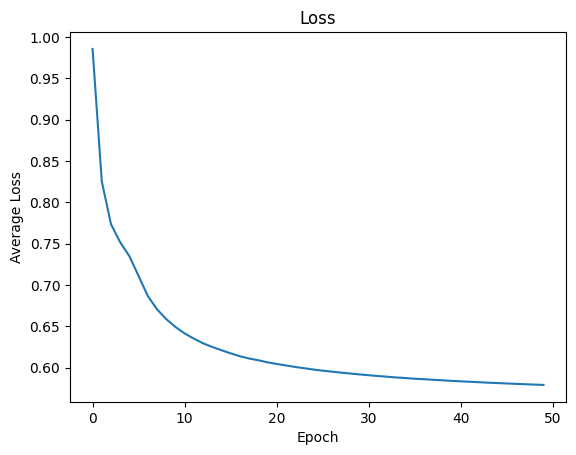

In [70]:
# plot the loss
L = torch.sum(losses,axis=0)/batch_size
plt.plot(L)
plt.title('Loss')

# add x and y labels

plt.xlabel('Epoch')
plt.ylabel('Average Loss')


plt.show()


/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_806/1883341664.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(torch.nn.functional.softmax(X))


Accuracy of the network on the 300 training paths: 98 %


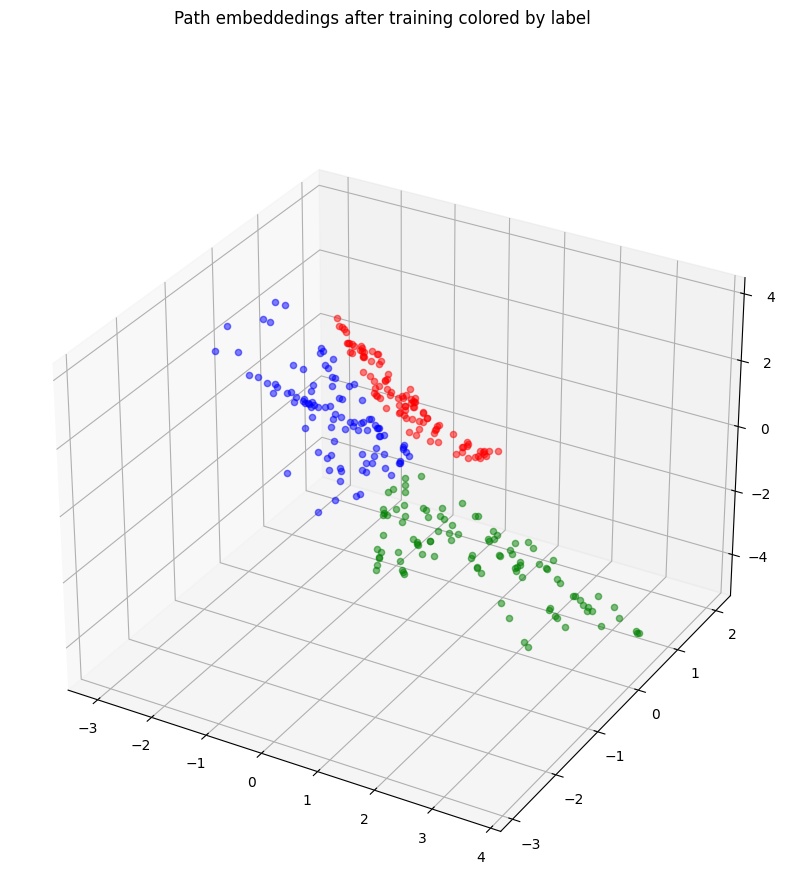

In [71]:
# make a 3d scatter plot of vf evaluated on the set of paths, colored by labels
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

# evaluate the accuracy of the classifier on the training data
correct = 0
total = 0

for i in range(len(paths)):
        
        p = paths[i]
        l = labels[i]
        
        p = path_to_chain(p)
        X = gen_CDM2(vf, p)
        
        X = torch.sum(X, dim = 0)/path_length(p)

        lb = torch.argmax(l)

        pred = torch.argmax(torch.nn.functional.softmax(X))

        if pred == torch.argmax(l):
                correct += 1
        total += 1
        
        
        if lb == 0:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'green', alpha = 0.5)
        elif lb == 1:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'red', alpha = 0.5)
        elif lb == 2:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), X[2].detach().numpy(), color = 'blue', alpha = 0.5)


print('Accuracy of the network on the 300 training paths: %d %%' % (100 * correct / total))

# add a title to the figure
fig.suptitle('Path embeddedings after training colored by label')

plt.show()



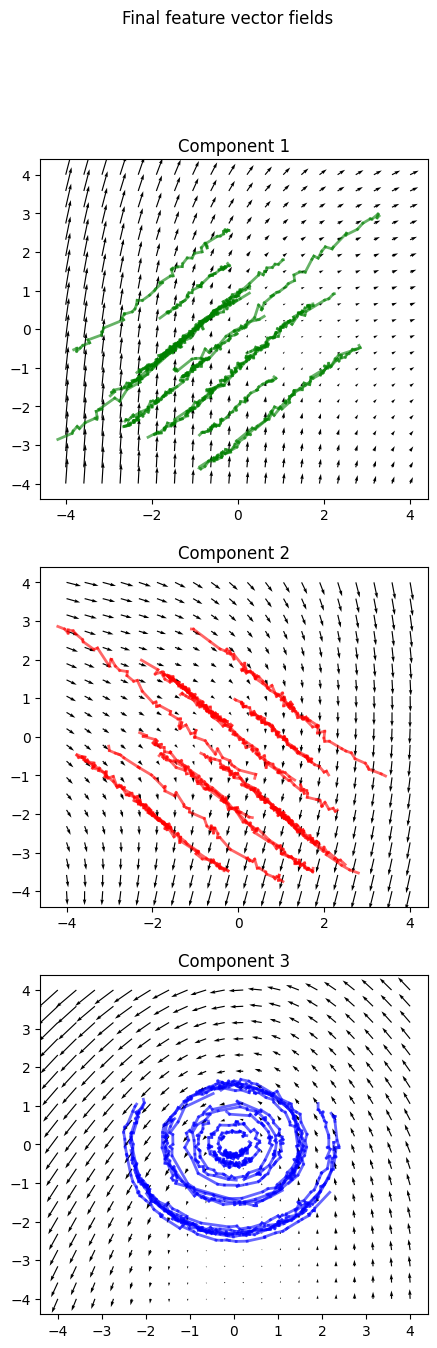

In [72]:
fig, axs = plt.subplots(3, 1, figsize=(5, 15))

for i in range(3):
    ax = axs[i]
    plot_component_vf(vf, ax, comp = i, x_range=4, y_range=4)
    ax.set_title('Component {}'.format(i+1))

# add a title to the figure
fig.suptitle('Final feature vector fields')



for i in range(20):

    plot_points(paths[0+i], axs[0], color = 'green', alpha = 0.6, linewidth = 2)

    plot_points(paths[100+i], axs[1], color = 'red', alpha = 0.6, linewidth = 2)

    plot_points(paths[200+i], axs[2], color = 'blue', alpha = 0.6, linewidth = 2)

plt.show()

## Check with manual initial weights

In [186]:
class LengthSigmoid(nn.Module):
    """
    A custom layer that takes normalises the vectors in the vector field
    by the sigmoid of their norm
    """
    def __init__(self, m):
        super().__init__()
        self.m = m # embedding dimension

    def forward(self, x):
        x = x.reshape(self.m,-1)
        lengths = torch.diag(torch.sqrt(x.T @ x))

        x = x * (1/lengths)

        x = x * torch.sigmoid(lengths)

        x = x.reshape(1,-1)

        return x


In [181]:
vf2 = nn.Sequential(
    nn.Linear(2, 6),
    LengthSigmoid(2),
)

In [182]:
vf2[0].weight.data = torch.tensor([[0,0],[0,0],[0,-1],[0,0],[0,0],[1,0]], dtype=torch.float)

In [183]:
vf2[0].bias.data = torch.tensor([1,1,0,1,-1,0], dtype=torch.float)

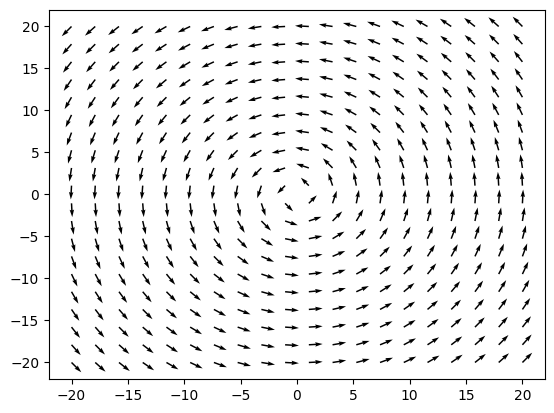

In [184]:
fig, ax = plt.subplots()

plot_component_vf(vf2, ax, comp=2, x_range=20, y_range=20)

plt.show()

In [175]:
orig_labels = np.concatenate((np.zeros(100),np.ones(100),2*np.ones(100)))


correct_pred = 0

for i in range(len(paths)):

    p = paths[i]
    y = labels[i]
    
    X = generate_cochain_dm(vf2, p, n = 5)

    # sum up columns of X using torch
    X = torch.sum(X, dim = 0)

    sm = torch.nn.functional.softmax(X)

    # get the index of the max log-probability
    pred = sm.argmax(dim=0, keepdim=True)

    if pred == orig_labels[i]:
        correct_pred += 1
    




print(correct_pred/len(paths))

/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_822/4080481592.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sm = torch.nn.functional.softmax(X)


1.0


In [89]:
X = generate_cochain_dm(vf2, paths[0], n = 5)
X


tensor([[ 0.1314, -0.0144, -0.5052],
        [ 0.0529, -0.1338, -0.3612],
        [ 0.1415,  0.0312, -0.4657],
        [ 0.1104, -0.3317, -0.8718],
        [ 0.1013,  0.0279, -0.2888],
        [ 0.2651,  0.0974, -0.7158],
        [ 0.2787, -0.5371, -1.9705],
        [ 0.4951, -0.2496, -1.9624],
        [ 0.2668, -0.4062, -1.7850]], grad_fn=<CopySlices>)

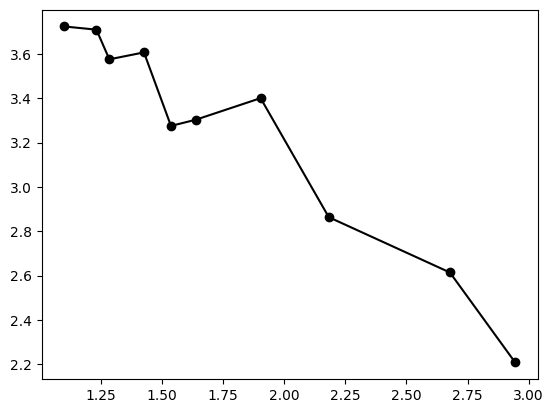

In [107]:
# write a function to plot a path as a scatter with lines joining the points
def plot_path(path, ax, color = 'black'):
    ax.scatter(path[:,0], path[:,1], color = color)
    for i in range(len(path)-1):
        ax.plot(path[i:i+2,0], path[i:i+2,1], color = color)

fig, ax = plt.subplots()

plot_path(paths[0], ax, color = 'black')



tensor([[-1.1477, -1.2494,  1.9954],
        [-2.5538, -0.5393,  2.9158],
        [ 0.1183,  0.4149,  0.0976],
        [-0.5279,  0.1472,  0.6389],
        [-0.7230,  2.3516,  2.5981],
        [ 0.4550,  1.1439,  1.4163],
        [ 1.1423,  0.8550,  1.6691],
        [ 3.2466, -2.0602,  3.1082],
        [-0.3627, -0.8486,  1.0109]], grad_fn=<CopySlices>)
prediction:  [0. 0. 1.] label:  tensor([0, 0, 1])


/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_822/3871740759.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.softmax(torch.sum(X,axis=0))


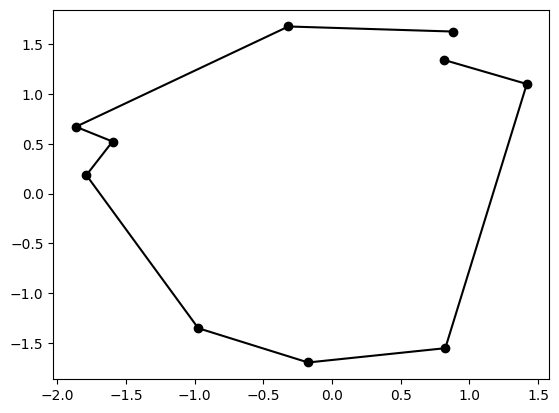

In [126]:
k = 260

X = generate_cochain_dm(vf2, paths[k], n = 5)

print(X)

pred = torch.nn.functional.softmax(torch.sum(X,axis=0))

# display the predictions up to 3 decimal places
print("prediction: ", np.round(pred.detach().numpy(),2), "label: ", labels[k])



fig, ax = plt.subplots()

plot_path(paths[k], ax, color = 'black')

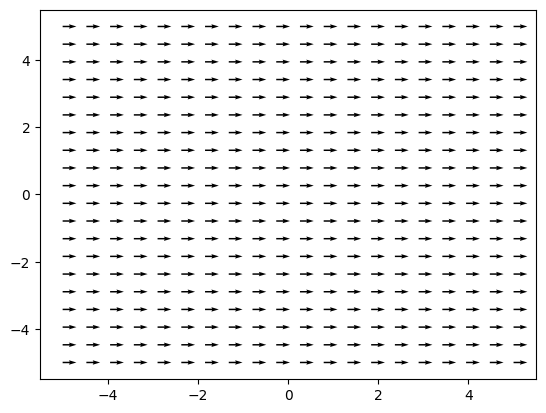

In [99]:
fig, ax = plt.subplots()

plot_component_vf(vf2, ax, comp=0, x_range=-5, y_range=5)

plt.show()